# Логистическая регрессия - исследование и оценка метода

**Цели работы**: предсказать склонность клиента откликнуться на предложение банка c помощью модели логистической регрессии, выбрать порог предсказания и гиперпараметры модели; сравнить работу этой модели с методом k-ближайших соседей.  

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение. Цель заключается в том, чтобы создать алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.  


**Задачи работы**:  
*  Загрузить данные для задачи.  
*  Обучить метод ближайших соседей с заданным количеством соседей `k = 9`, вычислить метрики.  
*  Обучить логистическую регрессию с параметрами по умолчанию, вычислить метрики.  
*  Подобрать порог модели, вычислить метрики.  
*  Подобрать гиперпараметр `С` (константа регуляризации) модели, вычислить метрики.  

**Описание данных**: информация находится в файле `database.dump`, который представляет собой резервную копию базы данных `PostgreSQL`, эта база данных хранит информацию о клиентах банка и их персональные данные, такие как пол, количество детей и другие.  
Необходимые данные:
1. `AGREEMENT_RK`, `TARGET` из таблицы `d_agreement`.  
2. `AGE`, `SOCSTATUS_WORK_FL`, `SOCSTATUS_PENS_FL`, `GENDER`, `CHILD_TOTAL`, `DEPENDANTS` из таблицы `d_clients`.  
3. `PERSONAL_INCOME` из таблицы `d_salary`.  
4. `LOAN_NUM_TOTAL`, `LOAN_NUM_CLOSED` из таблиц `d_loan` и `d_close_loan`.  

## Подготовка  


### Импорт библиотек  


In [30]:
import itertools
from typing import Union, List

from psycopg2 import connect as pgsql_connect
from psycopg2.extras import NamedTupleCursor

import pandas as pd
import numpy as np
import numpy.typing as npt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

### Полезные функции  


In [31]:
def plot_confusion_matrix(
    y_true: npt.ArrayLike, 
    y_pred: npt.ArrayLike, 
    classes: Union[List[str], None] = None, 
    normalize: bool = False, 
    title: str = 'Confusion Matrix'
) -> None:
    """Функция для отрисовки матрицы ошибок."""
    
    matrix = confusion_matrix(y_true, y_pred, normalize=('all' if normalize else None))

    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    classes = classes or range(len(matrix))
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt), 
                 horizontalalignment='center', 
                 color='white' if matrix[i, j] > thresh else 'black')


### Получение данных  

In [32]:
class PostgreSQLConnection:
    """Класс для подключения к базе данных PostgreSQL."""

    def __init__(self, dbname: str, user: str, password: str, host: str, port: str) -> None:
        """При инициализации класса необходимо задать данные для подключения к базе данных:  
        * `host` и `port` - адрес и порт сервера;  
        * `dbname` - название базы данных;  
        * `user` и `password` - логин и пароль к базе данных.
        """
        self.connection_parameters = {'host': host, 'port': port, 'dbname': dbname, 
                                      'user': user, 'password': password}
    
    def request(self, query: str) -> pd.DataFrame:
        """Выполняет запрос и возвращает результат в виде pandas.DataFrame."""
        with pgsql_connect(**self.connection_parameters) as connection:
            with connection.cursor(cursor_factory=NamedTupleCursor) as cursor:
                cursor.execute(query)
                response = pd.DataFrame(cursor.fetchall())
        return response

In [33]:
query = '''
    WITH loan_count AS (
        SELECT 
            l.id_client, 
            COUNT(l.id_loan) AS loan_num_total, 
            SUM(cl.closed_fl) AS loan_num_closed
        FROM d_loan AS l
        LEFT JOIN d_close_loan AS cl
            ON l.id_loan = cl.id_loan
        GROUP BY l.id_client)

    SELECT 
        a.agreement_rk, 
        a.target, 
        c.age, 
        c.socstatus_work_fl, 
        c.socstatus_pens_fl, 
        c.gender, 
        c.child_total, 
        c.dependants, 
        s.personal_income, 
        l.loan_num_total, 
        l.loan_num_closed
    
    FROM d_agreement AS a
    LEFT JOIN d_clients AS c
        ON a.id_client = c.id
    LEFT JOIN d_salary AS s
        ON a.id_client = s.id_client
    LEFT JOIN loan_count AS l
        ON a.id_client = l.id_client
'''

database = PostgreSQLConnection(dbname='postgres', user='postgres', password='1234', host='127.0.0.1', port='5432')
data = database.request(query).set_index('agreement_rk')

## Анализ и подготовка данных  


### Общая информация  


In [34]:
print(f'data.shape = {data.shape}')
data.head()

data.shape = (15523, 10)


,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_total,loan_num_closed
agreement_rk,,,,,,,,,,
62246916,0,42,2,1,0,0,0,20000.0,1,0
67011502,0,24,2,1,1,0,0,14000.0,1,1
63918955,0,28,2,1,0,0,0,15000.0,1,0
63633352,0,33,2,1,0,0,0,20000.0,1,1
62024377,0,47,2,1,1,2,0,25000.0,1,0


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15523 entries, 62246916 to 61847017
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   target             15523 non-null  object
 1   age                15523 non-null  object
 2   socstatus_work_fl  15523 non-null  object
 3   socstatus_pens_fl  15523 non-null  object
 4   gender             15523 non-null  object
 5   child_total        15523 non-null  object
 6   dependants         15523 non-null  object
 7   personal_income    15523 non-null  object
 8   loan_num_total     15523 non-null  int64 
 9   loan_num_closed    15523 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.3+ MB


In [36]:
data['target'].value_counts(dropna=False, normalize=True)

0    0.880629
1    0.119371
Name: target, dtype: float64

In [37]:
# Приведение типов 
data = data.astype(int)

### Разбиение датасета  

В этом ноутбуке нам придётся подбирать гиперпараметры модели, а ещё порог. Поэтому, чтобы не переобучиться, разобъём данные на тренировочную, валидационную и тестовую части.

*  Обучать модели будем на тренировочных данных.
*  Подбирать необходимые величины — по валидации.
*  Оценивать качество — на тесте.

In [38]:
X = data.copy()
y = X.pop('target')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=123)

print(f'Размер тренировочной выборки: {X_train.shape}, {y_train.shape}')
print(f'Размер валидационной выборки: {X_valid.shape}, {y_valid.shape}')
print(f'Размер тестовой выборки:      {X_test.shape}, {y_test.shape}')

Размер тренировочной выборки: (7606, 9), (7606,)
Размер валидационной выборки: (3260, 9), (3260,)
Размер тестовой выборки:      (4657, 9), (4657,)


## Обучение моделей  


### Метод k-ближайших соседей  

Обучим на тренировочных данных kNN с `k = 9` и выведем матрицу ошибок, а также значение метрик `precision` и `recall` на тестовых данных.  

In [39]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train);

Метрики метода ближайших соседей на тестовых данных:
	precision = 0.13043478260869565
	   recall = 0.00528169014084507


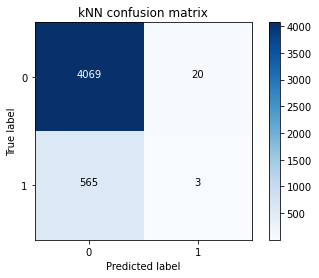

In [40]:
knn_predict = knn.predict(X_test)
print(f'Метрики метода ближайших соседей на тестовых данных:')
print(f'\tprecision = {precision_score(y_test, knn_predict)}')
print(f'\t   recall = {recall_score(y_test, knn_predict)}')
plot_confusion_matrix(y_test, knn_predict, title='kNN confusion matrix')

**Выводы**:  
* значение TN оказалось высоким скорее всего потому, что в данных наблюдается дисбаланс классов в пользу значения 0;  
* значение TP - низкое, что говорит о плохой работе модели - она плохо находит клиентов, которые бы откликнулись на предложение;  
* значения precision и recall низкие из-за низкого показателя TP.  

### Логистическая регрессия  

Обучим логистическую регрессию с параметрами по умолчанию и посмотрите на метрики: `confusion_matrix`, `precision` и `recall`.  


In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train);

Метрики логистической регрессии с параметрами по умолчанию:
	precision = 0.0
	   recall = 0.0


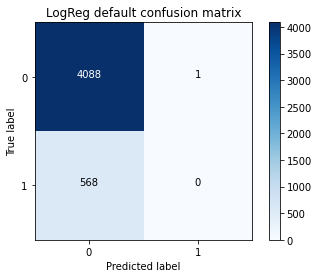

In [42]:
logreg_predict = logreg.predict(X_test)
print(f'Метрики логистической регрессии с параметрами по умолчанию:')
print(f'\tprecision = {precision_score(y_test, logreg_predict)}')
print(f'\t   recall = {recall_score(y_test, logreg_predict)}')
plot_confusion_matrix(y_test, logreg_predict, title='LogReg default confusion matrix')

Наша цель — найти как можно больше клиентов, которые откликнутся на предложение. А модель таких не находит. 

Мы помним, что метод `predict_proba` у логистической регрессии предсказывает математические (то есть корректные) вероятности классов. Предскажем вероятности классов с помощью обученной логистической регрессии на тестовых данных и выведем вероятности положительного класса для первых десяти объектов. 

**Вопрос**: Глядя на полученные вероятности, попробуйте объяснить, почему вы получили именно такую матрицу ошибок и такие значения точности с полноты.  
**Ответ**: Практически для всех объектов вероятность положительного класса очень низкая, она не дотягивает до порога 0.5. Правильно определенных объектов (`TP`) с положительным классом нет. А так как значение `TP` участвует в расчете метрик `precision` и `recall`, то и они имеют нулевое значение.

In [43]:
logreg_probas = logreg.predict_proba(X_test)

pd.DataFrame({'0_proba': logreg_probas[:10, 0], '1_proba': logreg_probas[:10, 1], 
              'predicted_class': logreg_predict[:10], 'true_class': y_test[:10]})

,0_proba,1_proba,predicted_class,true_class
agreement_rk,,,,
62375991,0.887095,0.112905,0,0
61441877,0.958940,0.041060,0,0
65411273,0.769467,0.230533,0,0
62263585,0.874015,0.125985,0,0
64552065,0.929162,0.070838,0,0
62138224,0.852717,0.147283,0,0
66583322,0.951900,0.048100,0,0
65419977,0.755791,0.244209,0,0
64445435,0.935100,0.064900,0,0


### Подбор порога для предсказаний логистической регрессии  

Уточним цель: Пусть нам нужно найти как можно больше клиентов, которые откликнутся на предложение, то есть максимизировать полноту (`recall`). При этом хочется, чтобы точность модели (`precision`) не была очень низкой. Заказчик посмотрел на результаты работы kNN и потребовал, чтобы точность была не ниже, чем у kNN: `precision` $\geq$ 0.13.  

Будем подбирать порог для перевода вероятности в классы по валидационной выборке, чтобы не переобучиться на тестовой.

In [44]:
valid_probas = logreg.predict_proba(X_valid)
best_threshold, best_recall, best_precision = 0, 0, 0

for threshold in np.arange(0.05, 1, 0.001):

    predictions = (valid_probas[:, 1] > threshold).astype(int)
    recall = recall_score(y_valid, predictions)
    precision = precision_score(y_valid, predictions)
    if precision >= 0.13 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_precision = precision

print(f'При пороге {best_threshold} метрики имеют следующие значения:')
print(f'\tprecision = {best_precision}')
print(f'\t   recall = {best_recall}')

При пороге 0.05800000000000001 метрики имеют следующие значения:
	precision = 0.13028828154249344
	   recall = 0.9230769230769231


Метрики логистической регрессии с порогом 0.058:
	precision = 0.1378579003181336
	   recall = 0.9154929577464789


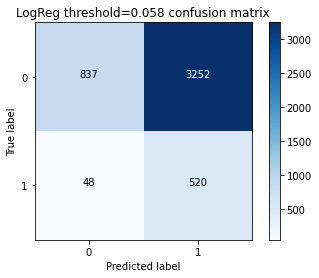

In [45]:
# Найдём тестовые метрики с этим порогом

threshold = round(best_threshold, 4)
predictions = (logreg_probas[:, 1] > threshold).astype(int)

print(f'Метрики логистической регрессии с порогом {threshold}:')
print(f'\tprecision = {precision_score(y_test, predictions)}')
print(f'\t   recall = {recall_score(y_test, predictions)}')
plot_confusion_matrix(y_test, predictions, title=f'LogReg threshold={threshold} confusion matrix')

**Вопрос**: Сделайте вывод. Смогли ли мы с помощью подбора порога добиться большего значения `recall`, чем у KNN?  
**Ответ**: С помощью подбора порога для перевода вероятности логистической регрессии в классы удалось увеличить значение полноты `recall` с 0.0053 (kNN) до 0.9155 (logreg with threshold=0.058), точность `precision` немного увеличилась с 0.1304 (kNN) до 0.1378 (logreg with threshold=0.058); в итоге полнота увеличилась значительно, а точность почти не изменилась, значит модель логистической регрессии с выбранным порогом работает куда лучше метода k-ближайших соседей.

### Подбор гиперпараметра C  

Подберём значение гиперпараметра `C` для логистической регрессии. Для этого обучим модели с разными значениями `C` (0.05, 0.15, ..., 10.05) и для каждой подберём оптимальный порог для перевода вероятностей в классы.

И найдём комбинацию `С` и порога такие, при которых полнота предсказаний модели максимальная, а точность не меньше 0.13.  


In [46]:
best_C = 0
best_threshold = 0
best_recall = 0 
best_precision = 0

for C in np.arange(0.05, 10.1, 0.1):
    
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    valid_probas = model.predict_proba(X_valid)

    for threshold in np.arange(0.05, 0.25, 0.001):

        predictions = (valid_probas[:, 1] > threshold).astype(int)
        recall = recall_score(y_valid, predictions)
        precision = precision_score(y_valid, predictions)
        if precision >= 0.13 and recall > best_recall:
            best_C = C
            best_recall = recall
            best_threshold = threshold
            best_precision = precision

print('Лучшая модель имеет следующие характеристики:')
print(f'best_C = {best_C}')
print(f'best_threshold = {best_threshold}')
print(f'best_recall = {best_recall}')
print(f'best_precision = {best_precision}')

Лучшая модель имеет следующие характеристики:
best_C = 0.05
best_threshold = 0.05800000000000001
best_recall = 0.9230769230769231
best_precision = 0.13028828154249344


Метрики логистической регрессии (C=0.05) с порогом 0.058:
	precision = 0.1378579003181336
	   recall = 0.9154929577464789


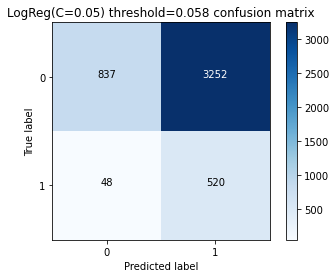

In [47]:
# Оценим лучшую модель на тестовых данных

best_logreg = LogisticRegression(C=best_C)
best_logreg.fit(X_train, y_train)

threshold = round(best_threshold, 4)
best_logreg_probas = best_logreg.predict_proba(X_test)
predictions = (best_logreg_probas[:, 1] > threshold).astype(int)

print(f'Метрики логистической регрессии (C={best_C}) с порогом {threshold}:')
print(f'\tprecision = {precision_score(y_test, predictions)}')
print(f'\t   recall = {recall_score(y_test, predictions)}')
plot_confusion_matrix(y_test, predictions, title=f'LogReg(С={best_C}) threshold={threshold} confusion matrix')

**Вопрос**: Влияет ли изменение гиперпараметра C на качество модели (и, соответственно, метрики) в этой задаче?  
**Ответ**: подбор гиперпараметра `C` не даёт значительных изменений метрик на тестовых данных, а значит говорить о важности гиперпараметра `C` в данной задаче нельзя.

**Вопросы**:    
1) Удалось ли при помощи логистической регрессии и подбора порога превзойти качество метода ближайших соседей в этой задаче?  
2) Смогли ли мы при помощи этой модели получить высокий recall при ограничениях, поставленных заказчиком?  

**Ответ**: При помощи логистической регрессии и подбора порога для перевода вероятности в классы удалось увеличить полноту предсказаний `recall` с 0.0053 у метода k-ближайших соседей до 0.9155 у логистической регрессии с порогом 0.058, хотя точность `precision` почти не изменилась (0.1304 у kNN, 0.1378 у logreg with threshold=0.058); в итоге полнота имеет высокое значение, а точность осталась в пределах ограничений заказчика, значит модель логистической регрессии с выбранным порогом превосходит модель k-ближайших соседей.  
